In [1]:
!pip install duckdb --no-index --find-links=file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
!pip install polars[numpy,pandas,pyarrow] --no-index --find-links=file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg

Looking in links: file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Processing /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg/duckdb-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Looking in links: file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import duckdb as dd
import polars as pl
import os
import glob
import shutil
import zipfile
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
!pip install plotly
import plotly.express as px
import librosa
from IPython.display import Audio
import pickle
from joblib import dump, load
from pathlib import Path
!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [5]:
def audio_waveframe(file_path):
    # Load the audio file
    audio_data, sampling_rate = librosa.load(file_path)
    # Calculate the duration of the audio file
    duration = len(audio_data) / sampling_rate
    # Create a time array for plotting
    time = np.arange(0, duration, 1/sampling_rate)
    # Plot the waveform
    plt.figure(figsize=(30, 4))
    plt.plot(time, audio_data, color='blue')
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plot = plt.show()
    return plot

def spectrogram(file_path):
    # Compute the short-time Fourier transform (STFT)
    n_fft = 500  # Number of FFT points 2048
    hop_length = 50  # Hop length for STFT 512
    audio_data, sampling_rate = librosa.load(file_path)
    stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
    # Convert the magnitude spectrogram to decibels (log scale)
    spectrogram = librosa.amplitude_to_db(np.abs(stft))
    # Plot the spectrogram
    plt.figure(figsize=(30, 6))
    librosa.display.specshow(spectrogram, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plot = plt.show()
    return plot

def audio_analysis(file_path):
    aw = audio_waveframe(file_path)
    spg = spectrogram(file_path)
    return aw, spg

In [6]:
meta_data = pl.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv', low_memory=True)
meta_data.head(5)

primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
str,str,str,f64,f64,str,str,str,str,f64,str,str
"""asbfly""","""[]""","""['call']""",39.2297,118.1987,"""Muscicapa dauu…","""Asian Brown Fl…","""Matt Slaymaker…","""Creative Commo…",5.0,"""https://www.xe…","""asbfly/XC13489…"
"""asbfly""","""[]""","""['song']""",51.403,104.6401,"""Muscicapa dauu…","""Asian Brown Fl…","""Magnus Hellstr…","""Creative Commo…",2.5,"""https://www.xe…","""asbfly/XC16484…"
"""asbfly""","""[]""","""['song']""",36.3319,127.3555,"""Muscicapa dauu…","""Asian Brown Fl…","""Stuart Fisher""","""Creative Commo…",2.5,"""https://www.xe…","""asbfly/XC17579…"
"""asbfly""","""[]""","""['call']""",21.1697,70.6005,"""Muscicapa dauu…","""Asian Brown Fl…","""vir joshi""","""Creative Commo…",4.0,"""https://www.xe…","""asbfly/XC20773…"
"""asbfly""","""[]""","""['call']""",15.5442,73.7733,"""Muscicapa dauu…","""Asian Brown Fl…","""Albert Lastukh…","""Creative Commo…",4.0,"""https://www.xe…","""asbfly/XC20921…"


In [14]:
[meta_data.filter((pl.col('primary_label')=='asbfly') & (pl.col('type')=="['song']")).select('filename')]

[shape: (14, 1)
 ┌─────────────────────┐
 │ filename            │
 │ ---                 │
 │ str                 │
 ╞═════════════════════╡
 │ asbfly/XC164848.ogg │
 │ asbfly/XC175797.ogg │
 │ asbfly/XC313835.ogg │
 │ asbfly/XC329259.ogg │
 │ asbfly/XC341611.ogg │
 │ …                   │
 │ asbfly/XC374520.ogg │
 │ asbfly/XC376509.ogg │
 │ asbfly/XC405069.ogg │
 │ asbfly/XC464609.ogg │
 │ asbfly/XC49755.ogg  │
 └─────────────────────┘]

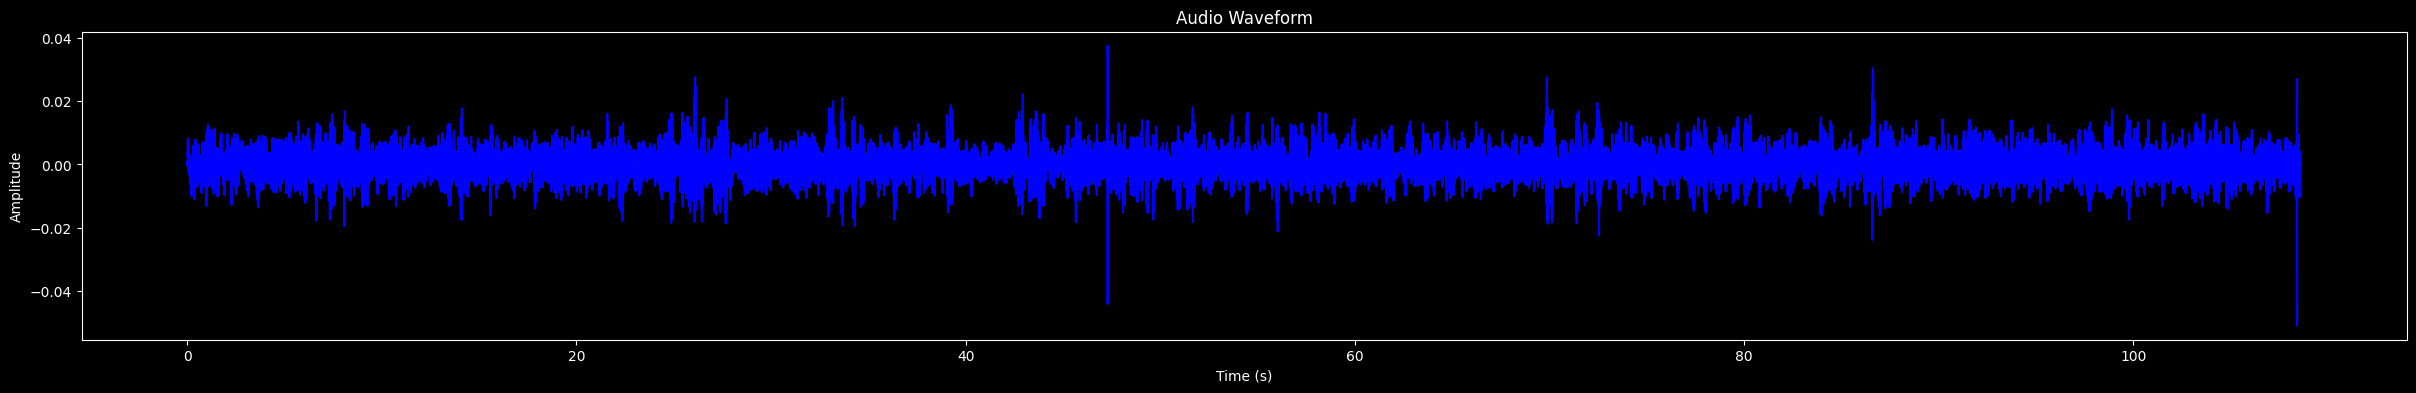

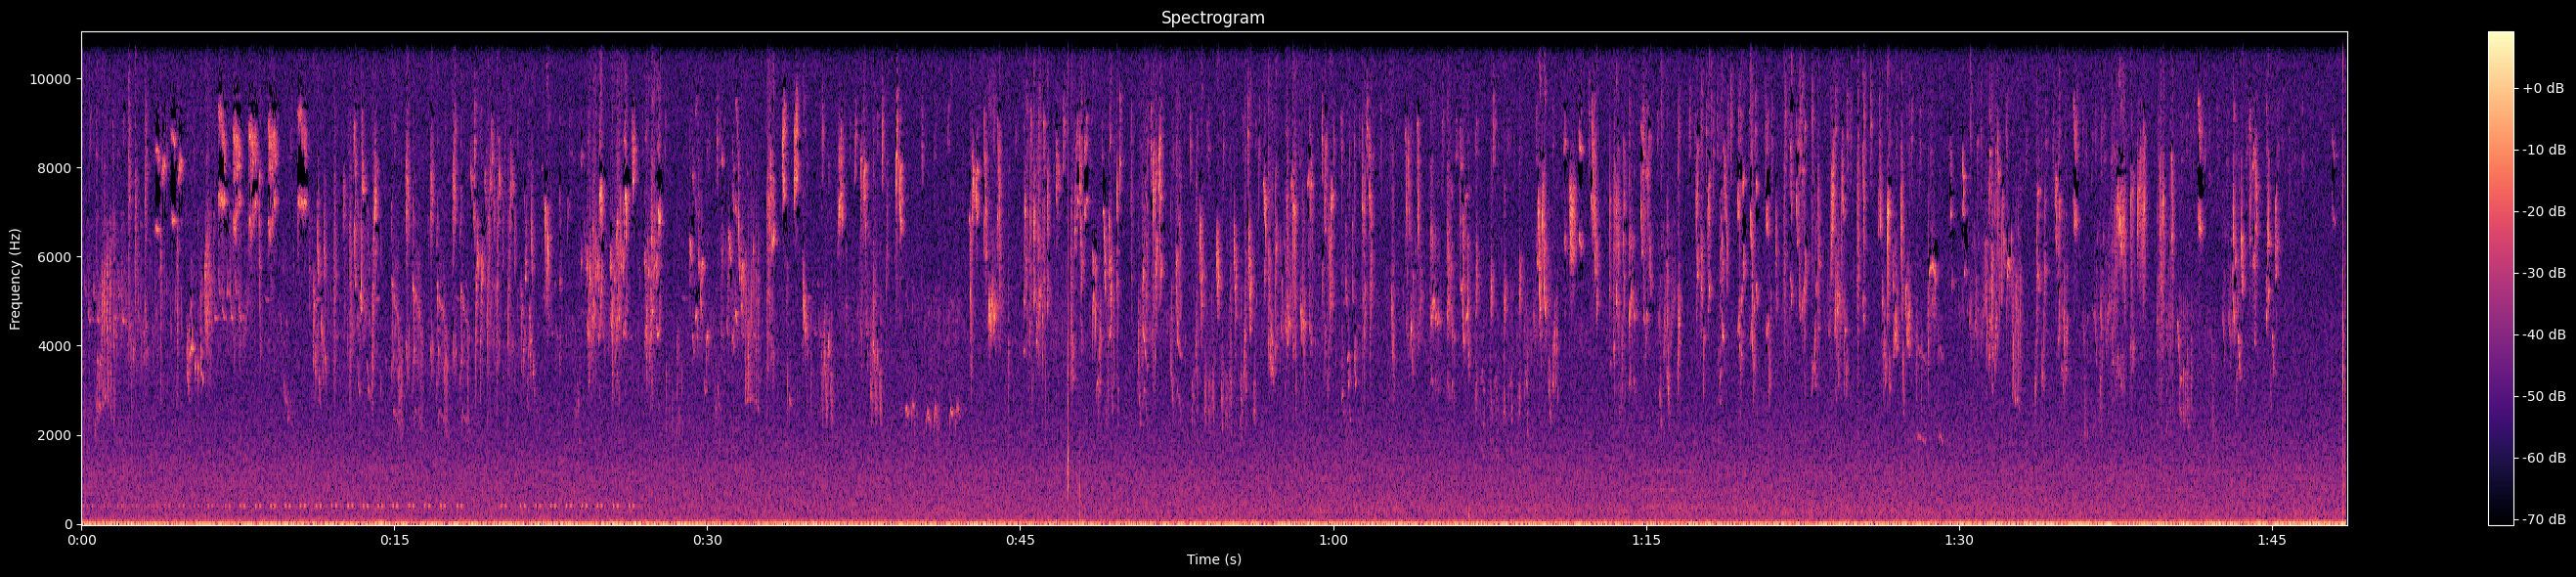

In [15]:
audio_analysis('/kaggle/input/birdclef-2024/train_audio/asbfly/XC374520.ogg')
Audio('/kaggle/input/birdclef-2024/train_audio/asbfly/XC374520.ogg')

In [3]:
with open("/kaggle/input/extracted-features-pickle/extracted_features", "rb") as file:
    pickled_extracted_features = pickle.load(file)

In [4]:
# Path to the directory containing your audio dataset
dataset_dir = '/kaggle/input/birdclef-2024/train_audio'
# Initialize an empty dictionary to store the mapping between audio files and labels
label_mapping = {}
# Iterate over subdirectories (classes) in the dataset directory
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    # Check if the item in the dataset directory is a directory
    if os.path.isdir(label_dir):
        # Iterate over audio files in the subdirectory (class)
        for audio_file in os.listdir(label_dir):
            # Add the mapping between audio file path and label to the dictionary
            audio_file_path = os.path.join(label_dir, audio_file)
            label_mapping[audio_file_path] = label
            
# label_mapping

# Create a list of tuples containing the audio file paths and labels
data = [(audio_file_path, label) for audio_file_path, label in label_mapping.items()]
# Create a Pandas DataFrame from the list of tuples
annotated_data = pd.DataFrame(data, columns=['audio_file_path', 'label'])

label_encoder = LabelEncoder()
annotated_data['encoded_label'] = label_encoder.fit_transform(annotated_data['label'])

annotated_data.head(10)

,audio_file_path,label,encoded_label
0,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
1,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
2,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
3,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
4,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
5,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
6,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
7,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
8,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
9,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137


In [16]:
x = np.vstack(pickled_extracted_features)
y = annotated_data['encoded_label']

print(x.shape)
print(y.shape)

(24459, 40)
(24459,)


In [17]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [38]:
"""ros = RandomOverSampler(random_state=42)
features_resampled, labels_reshampled = ros.fit_resample(x_train,y_train)
print(features_resampled.shape)
print(labels_reshampled.shape)"""

ros = RandomOverSampler(random_state=42)
features_resampled, labels_resampled = ros.fit_resample(x, y)

print(features_resampled.shape)
print(labels_resampled.shape)

(91000, 40)
(91000,)


In [39]:
unique_labels = labels_resampled.unique().sort()

x_train, x_test, y_train, y_test = train_test_split(features_resampled, labels_resampled, test_size=0.2, random_state=42)

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=4, coef0=1, C=5, probability=True))
])

poly_kernel_svm_clf.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=5, coef0=1, degree=4, kernel='poly', probability=True))])

In [43]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model = random_forest_classifier.fit(x_train, y_train)
#y_predict = random_forest_model.predict(x_test)

In [44]:
y_predict_rf = random_forest_model.predict_proba(x_test)

In [45]:
y_predict_rf.shape

(18200, 182)

In [48]:
#poly_kernel_svm_clf.predict_proba(features_resampled[0].reshape(-1, 1))

y_predict = poly_kernel_svm_clf.predict_proba(x_test)

In [49]:
y_predict.shape

(18200, 182)

In [42]:
y_test.shape

(18200,)

In [46]:
roc_score = roc_auc_score(y_test, y_predict_rf, multi_class='ovo', average='macro', labels=unique_labels)
print("ROC AUC Score:", roc_score)

ROC AUC Score: 0.983499125054007


In [50]:
roc_score = roc_auc_score(y_test, y_predict, multi_class='ovo', average='macro', labels=unique_labels)
print("ROC AUC Score:", roc_score)

ROC AUC Score: 0.9854957974305785
